In [2]:
'''
    Create venv that contains tapir (snowflake queries) and manatee (rrcf model) and add the venv as kernel option
    to the notebook:
        
        1. git clone https://github.com/NewKnowledge/tapir 
        2. cd tapir
        3. conda env create -n <name> -f environment.yml 
        4. python3 -m pip install git+https://github.com/NewKnowledge/manatee --process-dependency-links (wheels for
            rrcf having trouble, might have to clone, install from directory)
        5. python3 -m pip install ipykernel
        6. python -m ipykernel install --user --name myenv --display-name "Python (<name>)"
        7. set environment variables in venv by following these instructions: 
            https://conda.io/projects/conda/en/latest/user-guide/tasks/manage-environments.html#saving-environment-variables
        8. Select venv from Kernel -> Change Kernel -> Python (<name>)

    STEP 1: PULL MARCH HASHTAGS FROM SNOWFLAKE
'''

from tapir.queries import get_raw_training_data
from nk_logger import get_logger
from tapir.preprocess import prep_raw_data
logger = get_logger(__name__)

# constants
start_date = "2019-03-01"
stop_date = "2019-03-24"
min_count = 20

logger.info("collecting raw training data from snowflake")
get_raw_training_data(platform_id=28,min_count=min_count,start_date=start_date,stop_date=stop_date)
raw_data_fname_prefix = (f"hashtags_{start_date.replace('-', '_')}_to_{stop_date.replace('-', '_')}")

2019-03-26 11:59:27,238 - log.py:100 <module> - logger initialized


In [2]:
'''
    STEP 2: CONVERT RAW TIMESTAMPS TO RATE FUNCTIONS
''' 
# constants
bins_per_day = 24

training_data_fname = prep_raw_data(data_fname_prefix=raw_data_fname_prefix, bins_per_day = bins_per_day)


2019-03-25 15:00:20,006 - preprocess.py:30 prep_raw_data - reading raw data from files in data/raw/ with prefix: hashtags_2019_03_01_to_2019_03_24
2019-03-25 15:00:20,009 - preprocess.py:33 prep_raw_data - concat data from raw data fpaths: ['tapir/data/raw/hashtags_2019_03_01_to_2019_03_24__0_5_0.snappy.parquet', 'tapir/data/raw/hashtags_2019_03_01_to_2019_03_24__2_6_0.snappy.parquet', 'tapir/data/raw/hashtags_2019_03_01_to_2019_03_24__1_2_0.snappy.parquet', 'tapir/data/raw/hashtags_2019_03_01_to_2019_03_24__3_1_0.snappy.parquet', 'tapir/data/raw/hashtags_2019_03_01_to_2019_03_24__3_5_0.snappy.parquet', 'tapir/data/raw/hashtags_2019_03_01_to_2019_03_24__1_6_0.snappy.parquet', 'tapir/data/raw/hashtags_2019_03_01_to_2019_03_24__2_2_0.snappy.parquet', 'tapir/data/raw/hashtags_2019_03_01_to_2019_03_24__0_1_0.snappy.parquet', 'tapir/data/raw/hashtags_2019_03_01_to_2019_03_24__0_4_0.snappy.parquet', 'tapir/data/raw/hashtags_2019_03_01_to_2019_03_24__2_7_0.snappy.parquet', 'tapir/data/raw/has

/anaconda3/envs/time_series/lib/python3.7/site-packages/pyarrow/pandas_compat.py:752: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels, = index.labels


2019-03-25 15:00:37,424 - preprocess.py:38 prep_raw_data - grouping hashtag event times
2019-03-25 15:00:55,295 - preprocess.py:49 prep_raw_data - converting timestamps to floats of days since start_time
2019-03-25 15:01:37,483 - preprocess.py:58 prep_raw_data - smoothing rate functions (used to find emerging hashtags)
2019-03-25 15:01:43,193 - preprocess.py:65 prep_raw_data - converting to rate function took: 5.708946228027344 seconds
2019-03-25 15:01:43,194 - preprocess.py:68 prep_raw_data - writing rates to file tapir/data/prep/hashtags_2019_03_01_to_2019_03_24.npz


In [208]:
'''
    STEP 3: Data Preparation: round low rate_values, pad hashtags with 0s, calculate percentiles for random sample of hashtags

'''
import numpy as np
from datetime import datetime, timedelta
from manatee.robust_rcf import robust_rcf

# constants
sample_size = 100  # how many hashtag samples to calculate percentiles on which to make anom_prediction 
padding_in_hrs = 96 # pad hashtags with 0s to start to identify initial increases as anomalous
num_trees = 200
memory_in_hrs = 96 # the tree size of the forest (equivalent to how long in the past we want to remember)
min_rate = 100

# load data
prep_data_fpath = f"tapir/data/prep/" + raw_data_fname_prefix + ".npz"
data = np.load(prep_data_fpath)
n_ts, ts_sz = data['rate_vals'].shape
start_time = datetime.strptime(start_date, '%Y-%m-%d')
ts = [start_time + timedelta(days=t) for t in data['rate_times']]

'''
create timestamp features --> 
    doesn't really make sense because of local context of rrcf - generates false positives that make no sense when 
    day changes for example

ts_padding = [start_time - timedelta(days=data['rate_times'][0]*c) for c in range(padding_in_hrs)]
ts_features = np.array([[ts.year, ts.month, ts.day, ts.weekday(), ts.hour, ts.minute, ts.second] for ts in ts_padding + ts])
'''

# round low rate values
rates = data['rate_vals']
rates[rates < min_rate] = 0

# instantiate class
rcf = robust_rcf(num_trees, memory_in_hrs)

# this function controls the mean / variance calculation with one parameter: sample size
def anom_mean_var(sam_size):
    anomaly_scores = np.array([])
    for ix in np.random.randint(n_ts, size = sample_size):
        rate_vals = np.concatenate((np.zeros((padding_in_hrs, 1)), rates[ix].reshape(-1,1)), axis=0)
        #features = np.concatenate((rate_vals, ts_features), axis=1)
        rcf.fit_batch(rate_vals)
        anomaly_scores = np.append(anomaly_scores, rcf.batch_anomaly_scores().values)
    return anomaly_scores
    
# calculate mean and variance of sampled hashtags
anomaly_scores = anom_mean_var(sample_size)

0 points (0.0 %) weren't included in any randomly sampled trees:
0 points (0.0 %) weren't included in any randomly sampled trees:
0 points (0.0 %) weren't included in any randomly sampled trees:
0 points (0.0 %) weren't included in any randomly sampled trees:
0 points (0.0 %) weren't included in any randomly sampled trees:
0 points (0.0 %) weren't included in any randomly sampled trees:
0 points (0.0 %) weren't included in any randomly sampled trees:
0 points (0.0 %) weren't included in any randomly sampled trees:
0 points (0.0 %) weren't included in any randomly sampled trees:
0 points (0.0 %) weren't included in any randomly sampled trees:
0 points (0.0 %) weren't included in any randomly sampled trees:
0 points (0.0 %) weren't included in any randomly sampled trees:
0 points (0.0 %) weren't included in any randomly sampled trees:
0 points (0.0 %) weren't included in any randomly sampled trees:
0 points (0.0 %) weren't included in any randomly sampled trees:
0 points (0.0 %) weren't 

In [80]:
'''
    STEP 3b: compare the change in mean / variance as we change the sample size
'''

sample_sizes = [50,100,150]
for s in sample_sizes:
    logger.info(f"Calculating Mean and Variance at Sample Size {s}")
    anom_score_mean, anom_score_std = anom_mean_var(s)
    logger.info(f"Anomaly Score Mean: {anom_score_mean}")
    logger.info(f"Anomaly Score std: {anom_score_std}")   

Calculating Mean and Variance at Sample Size 50
0 points (0.0 %) weren't included in any randomly sampled trees:
0 points (0.0 %) weren't included in any randomly sampled trees:


KeyboardInterrupt: 

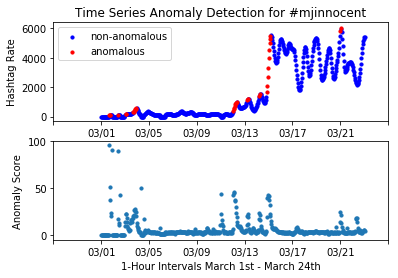

In [209]:
'''
    STEP 4: VISUALIZE ANOMALIES FOR TWEETS WE CARE ABOUT
'''
import matplotlib.pyplot as plt
import scipy.stats as st

# this function plots a graph of the hashtag, anomalies are labeled by a percentile threshold (parameter) and a graph
# of the anomaly scores (which could be mapped to some low / medium / high scale, for example, similar to product 
# dashboard)
def visualize_ht(hashtag, anom_percentile = 99.5, save = True):
    index = np.where(data['dataframe'][:,0] == hashtag)[0][0]
    features = np.concatenate((np.zeros((padding_in_hrs, 1)), rates[index].reshape(-1,1)), axis=0)
    anom_score = rcf.stream_anomaly_scores(features, window_size = 1, new_forest=True)
    
    # for this application, we just care about flagging positive anomalies -> set decreasing or 0 rate values to False
    decrease_mask = np.concatenate((np.array([False]), np.diff(features[padding_in_hrs:].reshape(-1)) < 0), axis=0)
    anom_pred = anom_score[padding_in_hrs:] > np.percentile(anomaly_scores, anom_percentile)
    anom_pred[decrease_mask] = False
    anom_pred[features[padding_in_hrs:].reshape(-1) == 0] = False
    
    # plot comparison of labeled anomalies to predicted anomalies
    colors = ('blue', 'red')
    targets = ('non-anomalous', 'anomalous')
    pred_indices = (np.where(~anom_pred), np.where(anom_pred))
    pred_data = (features[padding_in_hrs:][~anom_pred], features[padding_in_hrs:][anom_pred])
    plt.clf()
    plt.subplot(2, 1, 1)
    for index, dat, color, target in zip(pred_indices, pred_data, colors, targets):
        plt.scatter(index, dat, c = color, label = target, s=10)
    plt.xlabel('1-Hour Intervals March 1st - March 24th')
    locs, labs = plt.xticks()
    plt.xticks(locs, [''] + [t.strftime("%m/%d") for t in ts][::100])
    plt.ylabel('Hashtag Rate')
    plt.title(f"Time Series Anomaly Detection for #{hashtag}")
    plt.legend()
    plt.subplot(2, 1, 2)
    plt.scatter(range(len(anom_score[padding_in_hrs:])), anom_score[padding_in_hrs:],s=10)
    plt.ylabel('Anomaly Score')
    plt.xlabel('1-Hour Intervals March 1st - March 24th')
    plt.xticks(locs, [''] + [t.strftime("%m/%d") for t in ts][::100])
    plt.show() if not save else plt.savefig(f"{hashtag}.png")

visualize_ht('shallowbucks')
visualize_ht('mjinnocent')